<a href="https://colab.research.google.com/github/HendricoYehezky/Tugas-3-Modern-Convolutional-Neural-Network/blob/main/Chapter_7_6_Residual_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 462 kB 4.3 MB/s 


In [1]:
!pip install d2l

In [3]:
import tensorflow as tf
from d2l import tensorflow as d2l


class Residual(tf.keras.Model):  
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

In [4]:
blk = Residual(3)
X = tf.random.uniform((4, 6, 6, 3))
Y = blk(X)
Y.shape

TensorShape([4, 6, 6, 3])

In [5]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

TensorShape([4, 3, 3, 6])

In [6]:
b1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [7]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [8]:
b2 = ResnetBlock(64, 2, first_block=True)
b3 = ResnetBlock(128, 2)
b4 = ResnetBlock(256, 2)
b5 = ResnetBlock(512, 2)

In [9]:
# Recall that we define this as a function so we can reuse later and run it
# within `tf.distribute.MirroredStrategy`'s scope to utilize various
# computational resources, e.g. GPUs. Also note that even though we have
# created b1, b2, b3, b4, b5 but we will recreate them inside this function's
# scope instead
def net():
    return tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        ResnetBlock(64, 2, first_block=True),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),
        ResnetBlock(512, 2),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10)])

In [10]:
X = tf.random.uniform(shape=(1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2D output shape:	 (1, 112, 112, 64)
BatchNormalization output shape:	 (1, 112, 112, 64)
Activation output shape:	 (1, 112, 112, 64)
MaxPooling2D output shape:	 (1, 56, 56, 64)
ResnetBlock output shape:	 (1, 56, 56, 64)
ResnetBlock output shape:	 (1, 28, 28, 128)
ResnetBlock output shape:	 (1, 14, 14, 256)
ResnetBlock output shape:	 (1, 7, 7, 512)
GlobalAveragePooling2D output shape:	 (1, 512)
Dense output shape:	 (1, 10)


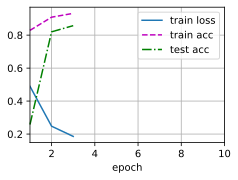

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())